In [1]:
import os
import google.genai as genai
from PIL import Image
from src.__init__ import GEMINI_API_KEY
# Gemini settings
GEMINI_MODEL_NAME: str = "gemini-2.5-pro-preview-06-05"

# Initialize Gemini client
_genai_client = genai.Client(api_key=GEMINI_API_KEY)

# Use the same image path as in sam2.py
image_path = os.path.join("data", "subway surfers", "08-06-25_at_19.33.00", "frames", "56.000_time.png")


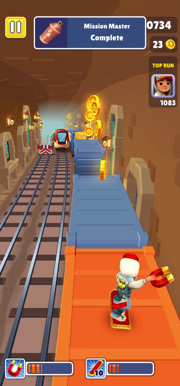

Image displayed at 1/8 size: 180x386 (original: 1440x3088)


In [2]:
# Display the image at 1/8 size
if os.path.exists(image_path):
    img = Image.open(image_path)
    # Calculate 1/8 size
    width, height = img.size
    new_size = (width // 8, height // 8)
    img_resized = img.resize(new_size)
    display(img_resized)
    print(f"Image displayed at 1/8 size: {new_size[0]}x{new_size[1]} (original: {width}x{height})")
else:
    print(f"Image file not found: {image_path}")


In [3]:

# Upload the image to Gemini
uploaded = _genai_client.files.upload(file=image_path)
print(f"⬆️ File uploaded to Gemini: {os.path.basename(image_path)}")

object_name = "gold coin"

prompt = (
    f"Detect the most prominent {object_name} object in the image. "
    "Most prominent means: standalone and not overlapping with a similar object (top priority)"
    "and out of standalone objects, choose the largest one (lower priority)"
    "(if there's overlap with a distinctly looking object and that distinctly looking"
    f"object is behind the {object_name}, that is OK bc it's still prominent)"
    f"If there are multiple {object_name} objects, make sure your bounding box is around the most prominent/standalone one"
    f"Respond **only** with a JSON dict which is either empty (if there is no compellingly prominent {object_name} in the image) or the JSON dict should have two keys: "
    "'label' and 'box_2d' (format [ymin, xmin, ymax, xmax] "
    "normalized 0-1000). Return nothing else. DO NOT return a list even if there are multiple objects."
    "DO NOT return a small object - one where both width or height are less than 5% of the image size."
    "Choose the most prominent one. Make absolutely sure the box you output is around the image, not intersecting with it."
    "If you're uncertain, prefer to return an empty dict, avoid false positives."
)

response = _genai_client.models.generate_content(
    model=GEMINI_MODEL_NAME,
    contents=[uploaded, prompt],
)
print(f"✅ Gemini response received")

⬆️ File uploaded to Gemini: 56.000_time.png
✅ Gemini response received


In [4]:
print(f"🤖 Gemini response: {response.text}")

# Parse the JSON response
import json
try:
    result_json = json.loads(response.text.strip())
    print(f"📝 Parsed JSON: {result_json}")
    
    if result_json and 'box_2d' in result_json:
        # Extract normalized coordinates (0-1000)
        ymin, xmin, ymax, xmax = result_json['box_2d']
        print(f"🔢 Normalized coords (0-1000): ymin={ymin}, xmin={xmin}, ymax={ymax}, xmax={xmax}")
        
        # Convert to actual image dimensions
        width, height = img.size
        actual_xmin = int(xmin * width / 1000)
        actual_ymin = int(ymin * height / 1000)
        actual_xmax = int(xmax * width / 1000)
        actual_ymax = int(ymax * height / 1000)
        
        print(f"📐 Actual pixel coords: xmin={actual_xmin}, ymin={actual_ymin}, xmax={actual_xmax}, ymax={actual_ymax}")
        print(f"📏 Box dimensions: {actual_xmax - actual_xmin}x{actual_ymax - actual_ymin} pixels")
    else:
        print("❌ No object detected or invalid response format")
        
except json.JSONDecodeError as e:
    print(f"❌ Failed to parse JSON response: {e}")


🤖 Gemini response: ```json
{"box_2d": [455, 603, 520, 672], "label": "gold coin"}
```
❌ Failed to parse JSON response: Expecting value: line 1 column 1 (char 0)
